<a href="https://colab.research.google.com/github/starkky07/FakeNewsDetection/blob/master/Liar_Liar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""Some important imports"""
import operator
import json
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles, make_classification,make_blobs,load_iris
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_score
from sklearn.metrics import accuracy_score,roc_auc_score, confusion_matrix, mean_squared_error, log_loss, davies_bouldin_score, silhouette_score
from collections import OrderedDict
from IPython import display
np.random.seed(0)

#@title Beautifying_Plot

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cycler
colors = cycler('color',
                ['#EE6666', '#3388BB', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

In [ ]:
#getting datasets;
train_df = pd.read_csv('./train.tsv',sep="\t",names=['id','label','statement','subject','speaker','job', 'state','party',
                                                     'barely_true_cs','false_cs','half_true_cs','mostly_true_cs',	'pants_on_fire_cs',	'venue'])
test_df = pd.read_csv('./test.tsv',sep="\t",names=['id','label','statement','subject','speaker','job', 'state','party',
                                                     'barely_true_cs','false_cs','half_true_cs','mostly_true_cs',	'pants_on_fire_cs',	'venue'])
valid_df = pd.read_csv('./valid.tsv',sep="\t",names=['id','label','statement','subject','speaker','job', 'state','party',
                                                     'barely_true_cs','false_cs','half_true_cs','mostly_true_cs',	'pants_on_fire_cs',	'venue'])


In [ ]:
train_df.head()

,id,label,statement,subject,speaker,job,state,party,barely_true_cs,false_cs,half_true_cs,mostly_true_cs,pants_on_fire_cs,venue
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [ ]:
print('Train Shape', train_df.shape)
print("Test Shape", test_df.shape)
print("Valid Shape", valid_df.shape)

Train Shape (10240, 14)
Test Shape (1267, 14)
Valid Shape (1284, 14)


In [ ]:
truth = {'false':0.,'half-true':0.5,'mostly-true':0.75,'true':1.,'pants-fire':-0.25,'barely-true':0.25} 

false_statement = train_df[train_df['label'] == ('false' or 'pants-fire' or 'barely-true')]
true_statement = train_df[(train_df['label'] != ('false' or 'pants-fire' or 'barely-true'))]
print(false_statement.shape)
print(true_statement.shape)

(1995, 14)
(8245, 14)


In [ ]:
words_per_statement = false_statement["statement"].apply(lambda x: len(x.split()))
stdev_train = statistics.stdev(words_per_statement)
words_per_statement_f = words_per_statement.sum()/len(false_statement['statement'])

print ("The average number of words in a fake news article is ", words_per_statement_f)
print ("The standard deviation in fake news article lengths is ", stdev_train)

words_per_statement_tru = true_statement["statement"].apply(lambda x: len(x.split()))
stdev_train = statistics.stdev(words_per_statement)
words_per_statement_t = words_per_statement_tru.sum()/len(true_statement['statement'])

print ("The average number of words in a ral news article is ", words_per_statement_t)
print ("The standard deviation in real news article lengths is ", stdev_train)

The average number of words in a fake news article is  16.985463659147868
The standard deviation in fake news article lengths is  10.150734033917924
The average number of words in a ral news article is  18.257974530018192
The standard deviation in real news article lengths is  10.150734033917924


Text(0.5, 1.0, 'Number of Words in Fake News Article')

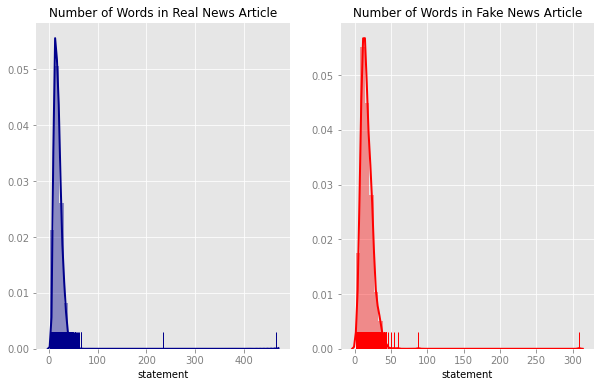

In [ ]:

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
sns.distplot(words_per_statement_tru, ax = ax[0], color = "darkblue", rug = True).set_title("Number of Words in Real News Article")
sns.distplot(words_per_statement, ax = ax[1], color = "red", rug = True).set_title("Number of Words in Fake News Article")

In [ ]:
## For tokenization and sentiment analysis
import re, string, random
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import twitter_samples, stopwords
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist, classify, NaiveBayesClassifier
nltk.download('wordnet')# is a lexical database for the English language that helps the script determine the base word
nltk.download('averaged_perceptron_tagger')#esource to determine the context of a word in a sentence.
nltk.download('stopwords')
nltk.download('twitter_samples')
nltk.download('word_tokenize')
nltk.download('punkt')
stop_words = stopwords.words('english')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Error loading word_tokenize: Package 'word_tokenize' not
[nltk_data]     found in index
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:


lemmatizer = WordNetLemmatizer()  

words_in_t = [] #all tokens in true articles
words_in_f = [] #all tokens in fake articles
words_in_each_article_t = [] #list of true articles, each in tokenized form
words_in_each_article_f = [] #list of fake articles, each in tokenized form
lemmatizer = WordNetLemmatizer()  
def process(df, word_list, by_article_list):
  for statement in (df["statement"]):
    words = word_tokenize(statement)
    words = [word.lower() for word in words if word.isalpha()] #lowercase
    words = [word for word in words if word not in string.punctuation and word not in stop_words] #punctuation, stopwords
    words = [lemmatizer.lemmatize(word) for word in words] #convert word to root form

    by_article_list.append(words)
    for w in words:
      word_list.append(w)

In [ ]:
process(false_statement, words_in_f, words_in_each_article_f)

In [ ]:
process(true_statement, words_in_t, words_in_each_article_t)

In [ ]:
len(words_in_each_article_t)

8245

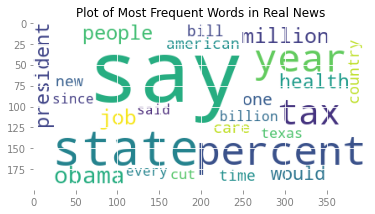

In [ ]:
from collections import Counter
from wordcloud import WordCloud
cnt = Counter(words_in_t)
# print(cnt.most_common(10))
# len(words_in_t[1:])
t_wc = WordCloud(max_words=25,relative_scaling=1,background_color ='white', normalize_plurals=False).generate_from_frequencies(dict(cnt))

plt.imshow(t_wc)
plt.title("Plot of Most Frequent Words in Real News")
plt.show()

In [ ]:
from collections import Counter
#To count in form of bigram, trigram and so on
bigrams_t = zip(words_in_t, words_in_t[1:])
bigrams_t_count = Counter(bigrams_t)
bigrams_t = pd.DataFrame(bigrams_t_count.most_common(20), columns= ['Bigrams', 'No of mentions'])
print(bigrams_t)


                Bigrams  No of mentions
0        (health, care)             303
1       (united, state)             248
2       (barack, obama)             217
3    (hillary, clinton)             155
4          (last, year)             118
5       (donald, trump)             117
6   (president, barack)             115
7    (president, obama)             114
8    (social, security)             103
9        (mitt, romney)              89
10  (health, insurance)              89
11      (scott, walker)              84
12      (rhode, island)              80
13           (tax, cut)              73
14       (say, hillary)              68
15          (year, say)              65
16        (new, jersey)              65
17     (say, president)              62
18        (say, donald)              60
19       (took, office)              59


In [ ]:
trigrams_t = zip(words_in_t, words_in_t[1:], words_in_t[2:])
trigrams_t_count = Counter(trigrams_t)
trigrams_t = pd.DataFrame(trigrams_t_count.most_common(20), columns= ['trigrams', 'No of mentions'])
print(trigrams_t)

                           trigrams  No of mentions
0        (president, barack, obama)              89
1           (say, hillary, clinton)              67
2              (say, donald, trump)              60
3               (say, mitt, romney)              48
4               (health, care, law)              48
5              (gov, scott, walker)              42
6          (say, president, barack)              41
7           (affordable, care, act)              31
8              (health, care, bill)              31
9              (health, care, plan)              30
10           (health, care, reform)              29
11             (say, barack, obama)              29
12      (president, barack, obamas)              25
13             (united, state, say)              21
14            (cent, every, dollar)              20
15             (say, scott, walker)              19
16              (say, marco, rubio)              18
17               (say, rick, perry)              17
18  (congres

In [ ]:
X = []
for a in words_in_each_article_t:
  X.append(a)
for b in words_in_each_article_f:
  X.append(b)

In [ ]:
#Keep words that appear in greater than 2% of documents. Override preprocessor and implement on list of words
#in each article in order to keep the words we have cleaned for earlier
tfidf = TfidfVectorizer(min_df=0.02, preprocessor = ' '.join)

#Implement on train dataset
response_train = tfidf.fit_transform(X) #This is the Sparse Document-Term Matrix
feature_names_train = tfidf.get_feature_names()
dense_train = response_train.todense() #This is the Dense Document-Term Matrix
denselist_train = dense_train.tolist()
X = pd.DataFrame(denselist_train, columns=feature_names_train)                       
X.head()

,america,american,barack,bill,billion,budget,care,city,clinton,cost,country,cut,day,dollar,even,every,federal,first,florida,get,government,governor,health,job,last,law,million,money,new,obama,obamacare,office,one,pay,people,percent,plan,president,public,rate,republican,said,say,school,scott,senate,since,spending,state,tax,texas,time,united,vote,voted,wisconsin,woman,would,year
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.939747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.341872
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000


In [ ]:
lemmatizer = WordNetLemmatizer()  
def process(df, word_list, by_article_list):
  for statement in (df["statement"]):
    words = word_tokenize(statement)
    words = [word.lower() for word in words if word.isalpha()] #lowercase
    words = [word for word in words if word not in string.punctuation and word not in stop_words] #punctuation, stopwords
    words = [lemmatizer.lemmatize(word) for word in words] #convert word to root form

    by_article_list.append(words)
    for w in words:
      word_list.append(w)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
truth = {'false':0.,'half-true':1,'mostly-true':1,'true':1.,'pants-fire':0,'barely-true':0} 

def Generate_words_ds(dataset):
  false_statement = dataset[dataset['label'] == ('false' or 'pants-fire' or 'barely-true')]
  true_statement = dataset[(dataset['label'] != ('false' or 'pants-fire' or 'barely-true'))]

  words_in_t = [] #all tokens in true articles
  words_in_f = [] #all tokens in fake articles
  X = []
  words_in_each_article_t = [] #list of true articles, each in tokenized form
  words_in_each_article_f = [] #list of fake articles, each in tokenized form
  process(false_statement, words_in_f, words_in_each_article_f)
  process(true_statement, words_in_t, words_in_each_article_t)
  print(len(words_in_each_article_t))
  print(len(words_in_each_article_f))
  for a in words_in_each_article_t:
    X.append(a)
  for b in words_in_each_article_f:
    X.append(b)
  #Keep words that appear in greater than 10% of documents.(can be done by min_df=0.1) but low accuracy
  #  Override preprocessor and implement on list of words
  #in each article in order to keep the words we have cleaned for earlier
  tfidf = TfidfVectorizer( preprocessor = ' '.join)

  #Implement on train dataset
  response_train = tfidf.fit_transform(X) #This is the Sparse Document-Term Matrix
  feature_names_train = tfidf.get_feature_names()
  dense_train = response_train.todense() #This is the Dense Document-Term Matrix
  denselist_train = dense_train.tolist()
  X = pd.DataFrame(denselist_train, columns=feature_names_train)                       
  return X, dataset['label'].apply(lambda x: truth[x])

##Twitter sample checking

In [ ]:
true_statement = twitter_samples.strings('positive_tweets.json')
false_statement = twitter_samples.strings('negative_tweets.json')

In [ ]:


lemmatizer = WordNetLemmatizer()  
def process(df, word_list, by_article_list):
  for statement in (df):
    words = word_tokenize(statement)
    for word in words:
      word = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                        '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', word)
      word = re.sub("(@[A-Za-z0-9_]+)"," ",word)
    words = [word.lower() for word in words if word.isalpha()] #lowercase
    words = [word for word in words if word not in string.punctuation and word not in stop_words] #punctuation, stopwords
    words = [lemmatizer.lemmatize(word) for word in words] #convert word to root form

    by_article_list.append(words)
    for w in words:
      word_list.append(w)

In [ ]:
words_in_t = [] #all tokens in true articles
words_in_f = [] #all tokens in fake articles
X = []
words_in_each_article_t = [] #list of true articles, each in tokenized form
words_in_each_article_f = [] #list of fake articles, each in tokenized form
process(false_statement, words_in_f, words_in_each_article_f)
process(true_statement, words_in_t, words_in_each_article_t)

In [ ]:
for a in words_in_each_article_t:
  X.append(a)
for b in words_in_each_article_f:
  X.append(b)
#Keep words that appear in greater than 10% of documents. Override preprocessor and implement on list of words
#in each article in order to keep the words we have cleaned for earlier
tfidf = TfidfVectorizer(min_df = 0.001, preprocessor = ' '.join)

#Implement on train dataset
response_train = tfidf.fit_transform(X) #This is the Sparse Document-Term Matrix
feature_names_train = tfidf.get_feature_names()
dense_train = response_train.todense() #This is the Dense Document-Term Matrix
denselist_train = dense_train.tolist()
X = pd.DataFrame(denselist_train, columns=feature_names_train)   

In [ ]:
y = pd.DataFrame([1 for i in range(0,5000)]+ [0 for i in range(0,5000)], columns={'label'})

In [ ]:
true_statement[1]

'@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!'

In [ ]:
X.head()

,able,absolutely,acc,account,act,actually,add,added,address,adeccowaytowork,af,afternoon,ago,agree,ah,ahh,ai,airport,album,almost,alone,already,also,always,amazing,amber,amp,annoying,another,answer,anymore,anyone,anything,anyway,app,apparently,appreciate,appreciated,around,arrived,...,without,wo,woke,woman,wonder,wonderful,wont,word,work,working,world,worry,worse,worst,worth,would,wow,write,wrong,wsalelove,wtf,xd,xx,xxx,ya,yay,yeah,year,yep,yes,yesterday,yet,yo,youre,youth,youtube,yup,zayn,zaynmalik,ｍｅ
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.384179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.49742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##Logistic Regression

In [ ]:
##Importing Different Classifiers
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc


In [ ]:
dataset = pd.concat([train_df, test_df])

In [ ]:

X,y = Generate_words_ds(dataset)
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.11, random_state=1)
print(X_test.shape)

9263
2244
(1266, 10316)


In [ ]:
L = LogisticRegression()
L.fit(X, np.ravel(y))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred =L.predict(X_test)
print("Accuracy Score is",accuracy_score(y_test,y_pred))
print("Mean Squared Error",mean_squared_error(y_test,y_pred))

Accuracy Score is 0.7345971563981043
Mean Squared Error 0.26540284360189575


In [ ]:
# Calculate predicted probabilities for test data 
y_pred_prob = L.predict_proba(X_test)[:, 1]

In [ ]:
roc_auc_score(y_test, y_pred_prob)

0.8231498285944747

In [ ]:
print(confusion_matrix(y_test, y_pred))

[[309 261]
 [ 75 621]]
